### Camera Gather Test Script
Run to check camera outputs in CV2, and compare stereo for integer assignments.

Left camera will have right-shifted image & vice versa.

2025-08-26 21:52:20.519 python[70776:1510928] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Available Cameras: [0, 1]


OpenCV: out device of bound (0-1): 2
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 3
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 4
OpenCV: camera failed to properly initialize!
Matplotlib is building the font cache; this may take a moment.


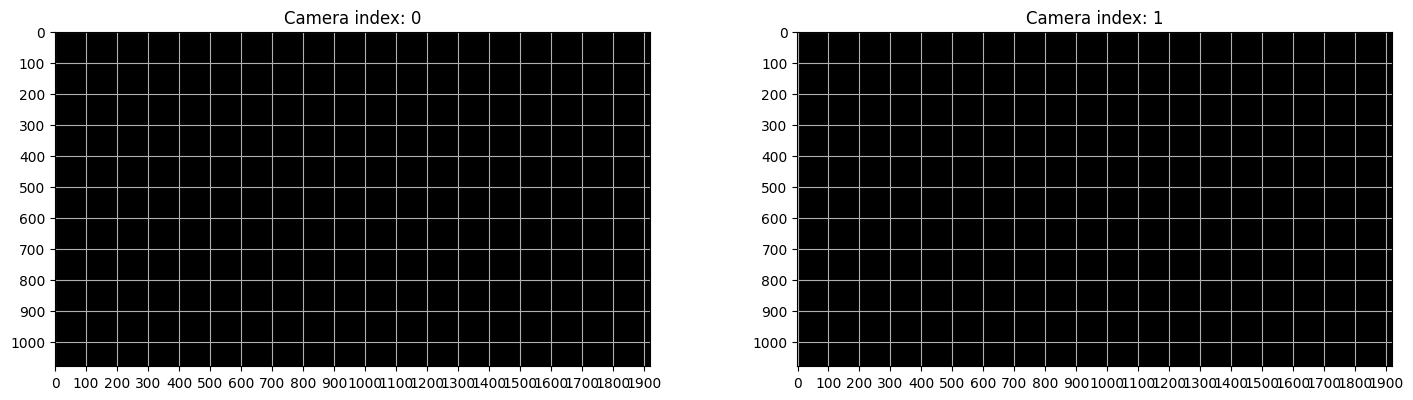

In [1]:
import cv2
import os
import sys
import numpy as np
from datetime import datetime

# Get Cameras on USB inputs
def get_available_cameras():
    available_cameras = []
    # Check for up to 5 cameras 
    for i in range(5):
        cap = cv2.VideoCapture(i)
        if cap.isOpened():
            available_cameras.append(i)
            cap.release()
    return available_cameras

cameras = get_available_cameras()
if cameras:
    print("Available Cameras:", cameras)
else:
    print("No cameras found.")
    sys.exit(1)

# Function to record from multiple cameras simultaneously
def record_multiple_cameras(camera_indices, output_dir, duration=None):
    """
    Record video from multiple cameras simultaneously
    
    Args:
        camera_indices: List of camera indices to record from
        output_dir: Directory to save videos
        duration: Recording duration in seconds (None for manual stop)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Create VideoCapture objects for each camera
    caps = {}
    outs = {}
    frame_sizes = {}
    
    # Initialize video writers
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = 30.0
    
    for cam_idx in camera_indices:
        cap = cv2.VideoCapture(cam_idx)
        if not cap.isOpened():
            print(f"Error: Camera {cam_idx} failed to open.")
            continue
        
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Failed to read from camera {cam_idx}")
            cap.release()
            continue
            
        frame_sizes[cam_idx] = (frame.shape[1], frame.shape[0])
        caps[cam_idx] = cap
        
        filename = os.path.join(output_dir, f'{timestamp}_camera{cam_idx}.avi')
        outs[cam_idx] = cv2.VideoWriter(filename, fourcc, fps, frame_sizes[cam_idx])
        print(f"Recording from camera {cam_idx} to {filename}")
    
    if not caps:
        print("No cameras available for recording.")
        return
    
    print("Recording started. Press 'q' to stop...")
    start_time = datetime.now()
    
    # Main recording loop
    try:
        while True:
            frames = {}
            for cam_idx, cap in caps.items():
                ret, frame = cap.read()
                if ret:
                    frames[cam_idx] = frame
                    outs[cam_idx].write(frame)
                else:
                    print(f"Warning: Failed to read from camera {cam_idx}")
            
            # Create a combined display of all cameras
            if frames:
                # Resize frames to a common size for display
                display_size = (320, 240)
                resized_frames = [cv2.resize(frames[cam_idx], display_size) for cam_idx in frames]
                
                # Create a grid layout
                n_cams = len(resized_frames)
                cols = min(n_cams, 3)
                rows = (n_cams + cols - 1) // cols
                
                # Create blank canvas
                display_height = rows * display_size[1]
                display_width = cols * display_size[0]
                canvas = np.zeros((display_height, display_width, 3), dtype=np.uint8)
                
                # Place frames on canvas
                for i, frame in enumerate(resized_frames):
                    row = i // cols
                    col = i % cols
                    y_start = row * display_size[1]
                    x_start = col * display_size[0]
                    canvas[y_start:y_start+display_size[1], x_start:x_start+display_size[0]] = frame
                
                cv2.imshow('Recording from multiple cameras', canvas)
            
            # Check for quit key or duration
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
            if duration and (datetime.now() - start_time).seconds >= duration:
                print(f"Recording complete ({duration} seconds)")
                break
                
    finally:
        # Clean up
        for out in outs.values():
            out.release()
        for cap in caps.values():
            cap.release()
        cv2.destroyAllWindows()
        print("Recording stopped.")

# Example of how to use the recording function
if __name__ == "__main__":
    # Use existing output_dir if defined in other cells, or ask user
    if 'output_dir' not in locals() and 'output_dir' not in globals():
        from pathlib import Path
        save_dir = input(f"Enter directory path to save videos: ").strip().strip('"').strip("'")
        experiment_name = input("Enter experiment name: ").strip().strip('"').strip("'")
        output_dir = os.path.join(Path.cwd(), save_dir, experiment_name) or Path.cwd()

    # Show camera preview using matplotlib
    import matplotlib.pyplot as plt
    n_cams = len(cameras)
    ncols = min(n_cams, 3)
    nrows = (n_cams + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows))
    if n_cams == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # Create VideoCapture objects for preview
    caps = {}
    for cam in cameras:
        cap = cv2.VideoCapture(cam)
        if cap.isOpened():
            ret, frame = cap.read()
            if ret:
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                ax = axes[cameras.index(cam)]
                ax.imshow(rgb_frame)
                ax.set_title(f'Camera index: {cam}')
                ax.grid(True)
                ax.set_xticks(np.arange(0, frame.shape[1], 100))
                ax.set_yticks(np.arange(0, frame.shape[0], 100))
            caps[cam] = cap

    plt.tight_layout()
    plt.show()

    for cap_obj in caps.values():
        cap_obj.release()
    
    # Ask user if they want to record
    record_choice = input("Do you want to record from these cameras? (y/n): ").lower()
    if record_choice == 'y':
        duration = input("Enter recording duration in seconds (or leave empty for manual stop): ")
        duration = int(duration) if duration.strip() else None
        record_multiple_cameras(cameras, output_dir, duration)


In [ ]:
print("This script will open a camera and save images to a specified directory.")
print("The images will be saved with the current date and time as the filename.")

from pathlib import Path
# In Jupyter Notebook, __file__ is not defined, so we use the current working directory instead.
ROOT = Path.cwd()
sys.path.append(str(ROOT))
print("Adding path to sys.path: ", str(ROOT))

# Create directory if it doesn't exist
save_dir = input(f"Enter the directory path to save images (from root {ROOT}): ").strip().strip('"').strip("'")
output_dir = os.path.join(ROOT, save_dir)
experiment_name = input("Enter the experiment name (folder for data): ").strip().strip('"').strip("'")
output_dir = os.path.join(output_dir, experiment_name)
os.makedirs(output_dir, exist_ok=True)

print("Saving to directory path: ", output_dir)
print("Reminder to share data when finished (consider zip compression)")


This script will open a camera and save images to a specified directory.
The images will be saved with the current date and time as the filename.
Adding path to sys.path:  c:\Users\liams\Documents\GitHub\ProjectSurgeryHernia\scene3d\stereo_acquisition
Saving to directory path:  c:\Users\liams\Documents\GitHub\ProjectSurgeryHernia\scene3d\stereo_acquisition\
Reminder to share data when finished (consider zip compression)


## 2-Camera Frame Grabber
Grab individual frames/videos with manual inputs

In [ ]:
import sys
import cv2
import os
from datetime import datetime
from PyQt5.QtWidgets import (
    QApplication, QWidget, QVBoxLayout, QHBoxLayout, QPushButton, QLabel, QMessageBox
)
from PyQt5.QtGui import QImage, QPixmap
from PyQt5.QtCore import QTimer

print("This script will open two cameras and save images from both cameras to a specified directory.")
print("It now supports recording chunks of video as well as snapping still frames.")

# Open the cameras
cap1 = cv2.VideoCapture(0)
cap2 = cv2.VideoCapture(1)
# For macOS users, you might need:
# cap1 = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
# cap2 = cv2.VideoCapture(1, cv2.CAP_AVFOUNDATION)

if not cap1.isOpened() or not cap2.isOpened():
    print("Error: One or both cameras failed to open.")
    exit(1)

# Create directory for saving data
output_dir = input("Enter the directory path to save images/video: ").strip().strip('"').strip("'")
experiment_name = input("Enter the experiment name (folder for data): ").strip().strip('"').strip("'")
output_dir = os.path.join(output_dir, experiment_name)
if not os.path.exists(output_dir):
    print("Directory does not exist... creating directory")
    os.makedirs(output_dir)
else:
    print("Directory exists... moving on")
print("Saving to directory path:", output_dir)
print("Reminder to share data when finished (consider zip compression)")

# Global counter for still images
image_counter = 0

class MainWindow(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Camera Dashboard")
        self.layout = QVBoxLayout()
        self.setLayout(self.layout)
        
        # Layout for camera feeds
        self.feed_layout = QHBoxLayout()
        self.label_cam0 = QLabel("Camera 0 Feed")
        self.label_cam1 = QLabel("Camera 1 Feed")
        self.feed_layout.addWidget(self.label_cam0)
        self.feed_layout.addWidget(self.label_cam1)
        self.layout.addLayout(self.feed_layout)
        
        # Button layout
        self.button_layout = QHBoxLayout()
        self.grab_button = QPushButton("Grab Frame")
        self.start_record_button = QPushButton("Start Recording Chunk")
        self.stop_record_button = QPushButton("Stop Recording Chunk")
        self.stop_record_button.setEnabled(False)  # disabled until recording starts
        self.exit_button = QPushButton("Exit")
        
        self.button_layout.addWidget(self.grab_button)
        self.button_layout.addWidget(self.start_record_button)
        self.button_layout.addWidget(self.stop_record_button)
        self.button_layout.addWidget(self.exit_button)
        self.layout.addLayout(self.button_layout)
        
        # Connect buttons
        self.grab_button.clicked.connect(self.on_grab_button_clicked)
        self.start_record_button.clicked.connect(self.start_recording)
        self.stop_record_button.clicked.connect(self.stop_recording)
        self.exit_button.clicked.connect(self.close_app)
        
        # Set up a QTimer for live preview updates
        self.timer = QTimer(self)
        self.timer.timeout.connect(self.update_display)
        self.timer.start(30)
        
        # Recording state and video writer holders
        self.recording = False
        self.video_writer0 = None
        self.video_writer1 = None
        self.record_filename0 = ""
        self.record_filename1 = ""
        self.fps = 20.0  # adjust as needed

    def update_display(self):
        """Grab frames from both cameras, update preview, and if recording, write frames."""
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if not ret1 or not ret2:
            return
        
        # If recording is active, write the current frames to video files.
        if self.recording and self.video_writer0 is not None and self.video_writer1 is not None:
            self.video_writer0.write(frame1)
            self.video_writer1.write(frame2)
        
        # Convert frames for display (BGR -> RGB)
        rgb_frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        rgb_frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
        
        # Convert to QImage for each feed
        h1, w1, ch1 = rgb_frame1.shape
        bytes_per_line1 = ch1 * w1
        qimg1 = QImage(rgb_frame1.data, w1, h1, bytes_per_line1, QImage.Format_RGB888)
        
        h2, w2, ch2 = rgb_frame2.shape
        bytes_per_line2 = ch2 * w2
        qimg2 = QImage(rgb_frame2.data, w2, h2, bytes_per_line2, QImage.Format_RGB888)
        
        # Update the labels
        self.label_cam0.setPixmap(QPixmap.fromImage(qimg1))
        self.label_cam1.setPixmap(QPixmap.fromImage(qimg2))
        
    def on_grab_button_clicked(self):
        """Snap and save still images with a confirmation dialog."""
        global image_counter
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if not ret1 or not ret2:
            print("Failed to grab frame(s)")
            return
        
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename0 = os.path.join(output_dir, f'camera0_{timestamp}_{image_counter}.jpg')
        filename1 = os.path.join(output_dir, f'camera1_{timestamp}_{image_counter}.jpg')
        
        reply = QMessageBox.question(
            self,
            "Confirm Save",
            f"Save still images to:\n{filename0}\nand\n{filename1}?",
            QMessageBox.Yes | QMessageBox.No,
            QMessageBox.Yes
        )
        
        if reply == QMessageBox.Yes:
            cv2.imwrite(filename0, frame1)
            cv2.imwrite(filename1, frame2)
            print(f"Images saved: {filename0}, {filename1}")
            image_counter += 1
        else:
            print("Still images not saved.")
    
    def start_recording(self):
        """Start recording a chunk of video from both cameras."""
        # Determine frame dimensions from one camera
        ret, frame = cap1.read()
        if not ret:
            QMessageBox.warning(self, "Error", "Cannot start recording; failed to grab frame from camera 0.")
            return
        height, width, _ = frame.shape
        
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.record_filename0 = os.path.join(output_dir, f'camera0_{timestamp}_chunk.avi')
        self.record_filename1 = os.path.join(output_dir, f'camera1_{timestamp}_chunk.avi')
        
        # Define codec and create VideoWriter objects for each camera
        fourcc = cv2.VideoWriter_fourcc(*'XVID')  # adjust codec if necessary
        self.video_writer0 = cv2.VideoWriter(self.record_filename0, fourcc, self.fps, (width, height))
        self.video_writer1 = cv2.VideoWriter(self.record_filename1, fourcc, self.fps, (width, height))
        
        self.recording = True
        self.start_record_button.setEnabled(False)
        self.stop_record_button.setEnabled(True)
        print("Recording started...")
    
    def stop_recording(self):
        """Stop recording the video chunk and ask for confirmation to save or discard."""
        if not self.recording:
            return
        
        self.recording = False
        # Release the video writers
        if self.video_writer0 is not None:
            self.video_writer0.release()
        if self.video_writer1 is not None:
            self.video_writer1.release()
        self.video_writer0 = None
        self.video_writer1 = None
        
        self.start_record_button.setEnabled(True)
        self.stop_record_button.setEnabled(False)
        print("Recording stopped.")
        
        # Ask user for confirmation to keep the recording
        reply = QMessageBox.question(
            self,
            "Confirm Save",
            f"Keep the recorded video chunk?\nCamera 0: {self.record_filename0}\nCamera 1: {self.record_filename1}",
            QMessageBox.Yes | QMessageBox.No,
            QMessageBox.Yes
        )
        if reply == QMessageBox.No:
            # Remove the files if user discards
            try:
                os.remove(self.record_filename0)
                os.remove(self.record_filename1)
                print("Recorded chunk discarded.")
            except Exception as e:
                print("Error discarding files:", e)
        else:
            print("Recorded chunk saved.")
    
    def close_app(self):
        """Cleanup and close the application."""
        self.timer.stop()
        cap1.release()
        cap2.release()
        self.close()

app = QApplication(sys.argv)
window = MainWindow()
window.show()
sys.exit(app.exec_())


This script will open two cameras and save images from both cameras to a specified directory.
The images will be saved with the current date and time as the filename.
Directory exists... moving on
Saving to directory path: data\test
Reminder to share data when finished (consider zip compression)
Images saved: data\test\camera0_20250220_211127_0.jpg, data\test\camera1_20250220_211127_0.jpg
Images saved: data\test\camera0_20250220_211131_1.jpg, data\test\camera1_20250220_211131_1.jpg
Images saved: data\test\camera0_20250220_211136_2.jpg, data\test\camera1_20250220_211136_2.jpg


SystemExit: 0

c:\Users\liams\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
print("This script will open two cameras and record video from both cameras to a specified directory.")
print("The videos will be saved with the current date and time as part of the filename.")

# Open the first camera
cap1 = cv2.VideoCapture(0)
# Open the second camera
cap2 = cv2.VideoCapture(1)

# For macOS users, you might need to use the AVFoundation backend:
# cap1 = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
# cap2 = cv2.VideoCapture(1, cv2.CAP_AVFOUNDATION)

if not cap1.isOpened() or not cap2.isOpened():
    print("Error: One or both cameras failed to open.")
    exit(1)

# Create directory for saving video if it doesn't exist
output_dir = input("Enter the directory path to save video files: ").strip().strip('"').strip("'")
experiment_name = input("Enter the experiment name (folder for data): ").strip().strip('"').strip("'")
output_dir = os.path.join(output_dir, experiment_name)
if not os.path.exists(output_dir):
    print("Directory does not exist... creating directory")
    os.makedirs(output_dir)
else:
    print("Directory exists... moving on")

print("Saving to directory path:", output_dir)
print("Reminder to share data when finished (consider zip compression)")
print("Recording video. Press 'q' to quit.")

# Read one frame from each camera to get frame dimensions
ret1, frame1 = cap1.read()
if not ret1:
    print("Failed to capture frame from camera 1.")
    exit(1)
frame_size1 = (frame1.shape[1], frame1.shape[0])

ret2, frame2 = cap2.read()
if not ret2:
    print("Failed to capture frame from camera 2.")
    exit(1)
frame_size2 = (frame2.shape[1], frame2.shape[0])

# Set frames per second and compression codec (adjust as needed)
fps = 30.0  # adjust the FPS based on your hardware
try:
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # 'XVID' is common on Windows; try 'MJPG' or others on macOS
except Exception as e:
    print(f"Error: Codec not found... {e}")
    exit(1)

# Use current datetime for naming the video files
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
video_filename1 = os.path.join(output_dir, f'{timestamp}_camera0.avi')
video_filename2 = os.path.join(output_dir, f'{timestamp}_camera1.avi')

# Create VideoWriter objects for each camera
out1 = cv2.VideoWriter(video_filename1, fourcc, fps, frame_size1)
out2 = cv2.VideoWriter(video_filename2, fourcc, fps, frame_size2)

while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    
    if not ret1 or not ret2:
        if not ret1:
            print("Failed to grab frame from camera 1")
        if not ret2:
            print("Failed to grab frame from camera 2")
        break
    
    # Write frames to the video files
    out1.write(frame1)
    out2.write(frame2)
    
    # Create a paneled view for display (side-by-side)
    combined_frame = cv2.hconcat([frame1, frame2])
    cv2.imshow('Paneled View [Camera 0, Camera 1]', combined_frame)
    
    # Press 'q' to quit recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release all resources
cap1.release()
cap2.release()
out1.release()
out2.release()
cv2.destroyAllWindows()
